In [74]:
%matplotlib inline #to show plots in notebook
# import the necessary packages
import numpy as np
import argparse
import glob
#import cv2 #need to install on this kernel
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import sobel, roberts
from skimage import feature
from skimage import measure
from skimage import morphology
from collections import Counter
import operator
from scipy import ndimage as ndi
from skimage import io

In [75]:
#parameters
lowClip = 6 # Percent of original image
highClip = 40

In [76]:
#choosing image
filename= '43378-17.png'
#filename= '43386-17.png'
#filename = "43375-17.png" # Strong
#filename = "43396-17.png" # Strong

[]

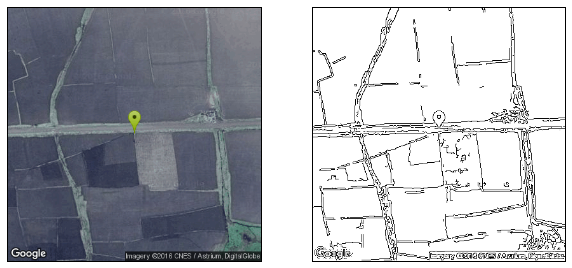

In [77]:
im = io.imread(filename, as_grey=True) #import image
im2 = io.imread(filename) #store a second version
imarr = np.asarray(im) #transform to numpy array

sigma=.8 #parameter for canny edge detection
edge_canny = feature.canny(imarr, sigma) 


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10)) 
ax1.imshow(im2, cmap="Greys")
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(edge_canny, cmap="Greys")
ax2.set_xticks([])
ax2.set_yticks([])

In [78]:
#dilation to close edges
dilat2 = morphology.binary_dilation(edge_canny)
dilat = morphology.binary_dilation(dilat2)

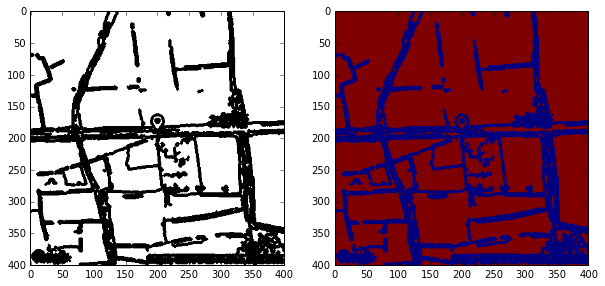

In [84]:
mask=(dilat==0)*1 #invert image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10)) #sharey=False)
ax1.imshow(dilat, cmap="Greys") #graph dilation
ax2.imshow(mask, cmap="Greys") #graph inverse
plt.imshow(mask,)

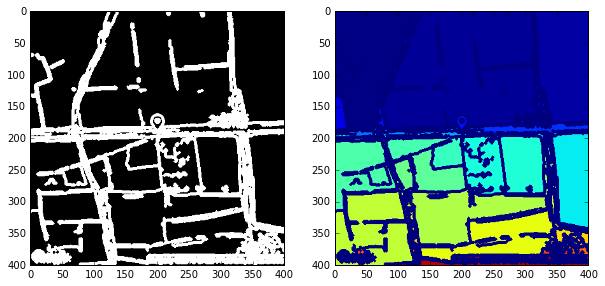

In [80]:
label_image = measure.label(mask)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10)) #sharey=False)
ax1.imshow(mask, cmap="Greys")
ax2.imshow(label_image)

In [81]:
pix = label_image.ravel()
rgns = Counter(pix)
sorted_rgns = np.asarray(sorted(rgns.items(), key=operator.itemgetter(1)))
lowerLimit = (lowClip/100)**2.0*np.shape(imarr)[0]*np.shape(imarr)[1]
upperLimit = (highClip/100)**2.0*np.shape(imarr)[0]*np.shape(imarr)[1]
mask2 = ((sorted_rgns[:,1] > lowerLimit) & (sorted_rgns[:,1] < upperLimit))
zones = sorted_rgns[mask2][:,0]

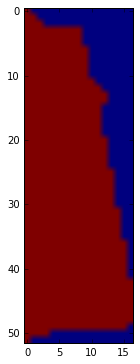

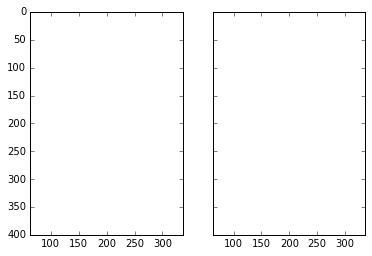

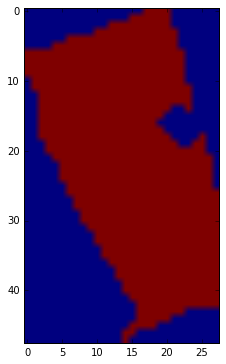

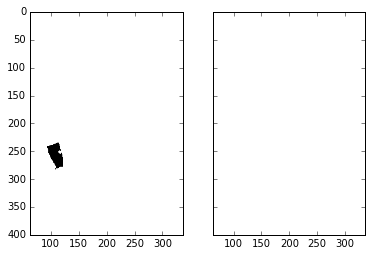

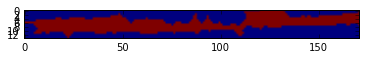

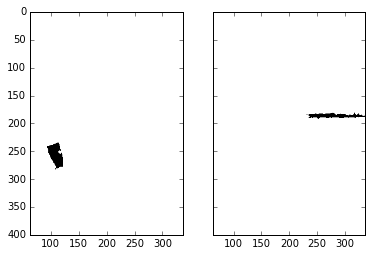

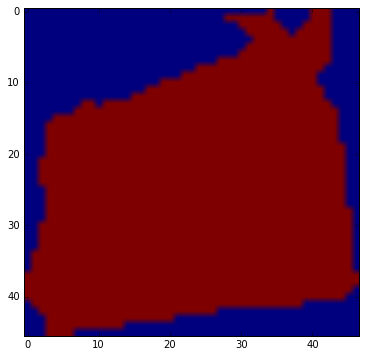

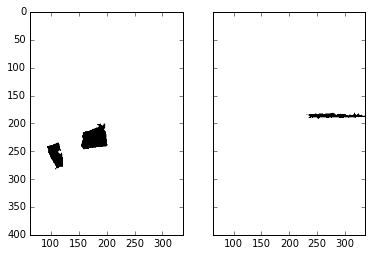

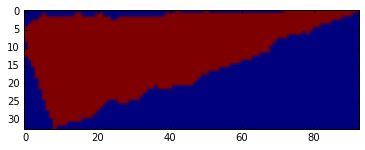

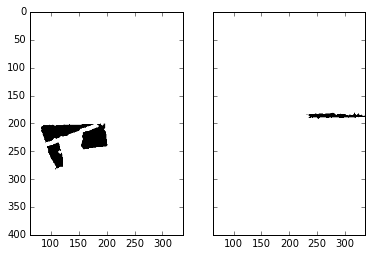

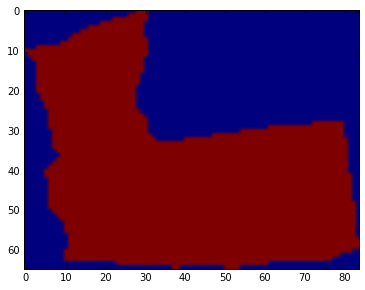

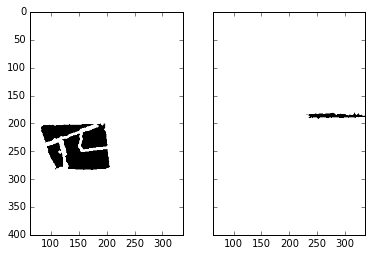

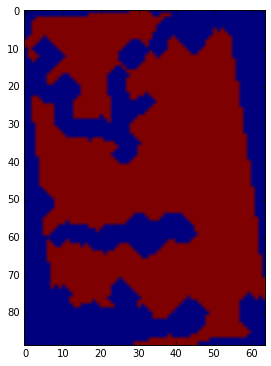

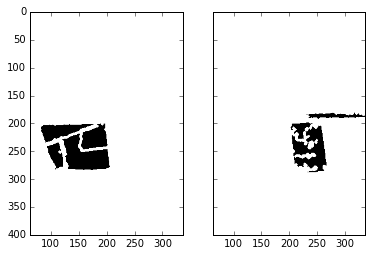

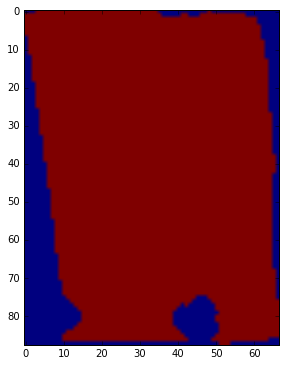

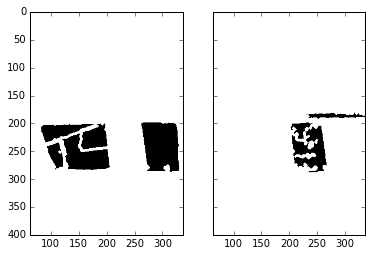

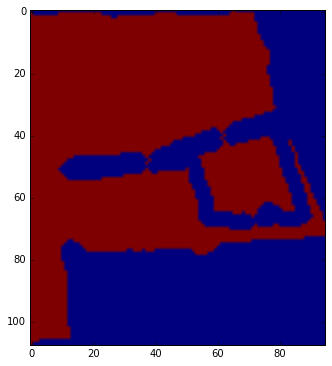

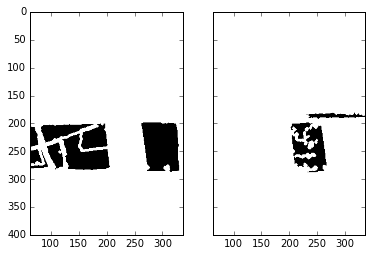

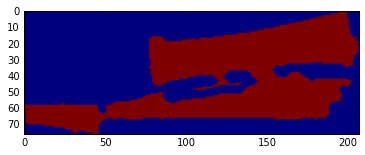

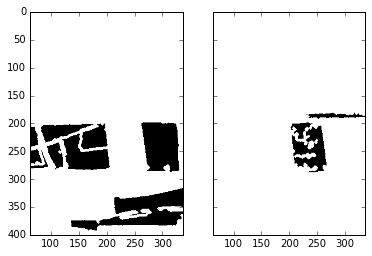

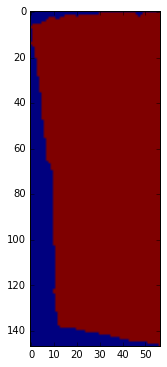

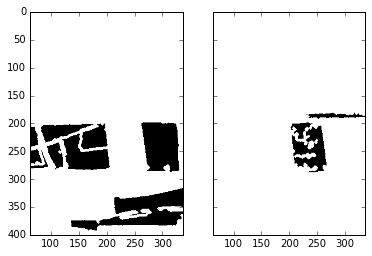

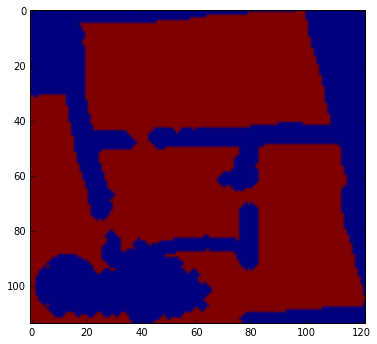

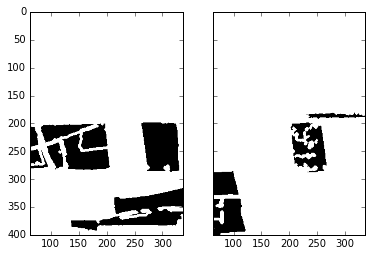

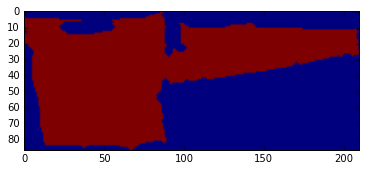

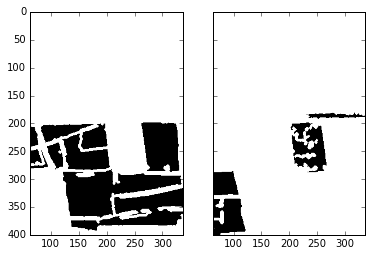

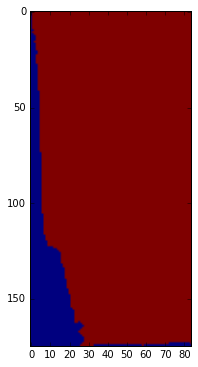

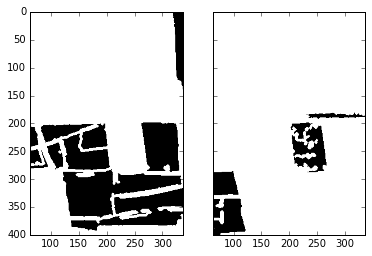

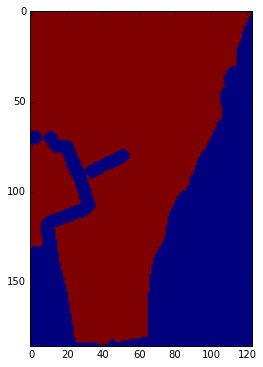

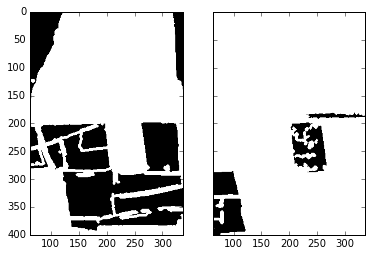

In [82]:
maskred = np.zeros_like(imarr)
maskgreen = np.zeros_like(imarr)

for z in zones:        
    zone = (label_image==z)*1
    bboxes = ndi.measurements.find_objects(zone)
    zoneCropHoles = zone[bboxes[0][0].start:bboxes[0][0].stop, bboxes[0][1].start:bboxes[0][1].stop]
    zoneCrop = ndi.binary_fill_holes(zoneCropHoles)
    plt.figure(figsize=(6,6))
    plt.imshow(zoneCrop)
    #plt.colorbar()
    plt.show()
    zoneCroppad = np.lib.pad(zoneCrop,(1,1),'constant',constant_values=0)
    edgeIm = sobel(zoneCroppad.astype('float64'))
    edgeIm[edgeIm > 0.01] = 1
    #need to improve field criteria, possiblly use 
    #harris edge detection
    if(sum(sum(edgeIm))/(2*(sum(np.asarray(np.shape(zoneCrop))))) > 4 \
        or max(np.shape(zoneCrop))/min(np.shape(zoneCrop)) > 4): 
        maskred[zone==1]=1
    else:
        maskgreen[zone==1]=1
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(maskgreen, cmap="Greys")
    ax2.imshow(maskred, cmap="Greys")
    plt.show()

[]

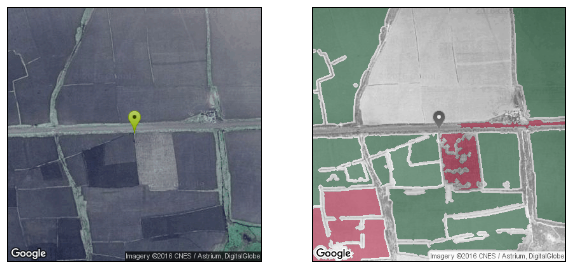

In [83]:
gmasked = np.ma.masked_where(maskgreen < 0.9, maskgreen)
rmasked = np.ma.masked_where(maskred < 0.9, maskred)
plt.figure(figsize=(6,6))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10)) #sharey=False)
ax1.imshow(im2)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(imarr, cmap="Greys")
ax2.imshow(gmasked, alpha=0.5, cmap="PRGn_r")
ax2.imshow(rmasked, alpha=0.5, cmap="RdYlBu")
plt.gca().set_xticks([])
plt.gca().set_yticks([])